بسم الله 

** Importing liberies and frameworks **

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


**Load videos and Preprocessing : ** defines a function load_video that takes a path to a video file as input and returns a preprocessed version of the video frames as a list of TensorFlow tensors lets eplain this with a simple graphe *

Test the function (LOad_video)

In [2]:
def load_video(path:str) -> List[float]:
    cap=cv2.VideoCapture(path)
    frames=[]
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame=tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean=tf.math.reduce_mean(frames)
    std=tf.math.reduce_std(tf.cast(frames,tf.float32))
    return tf.cast((frames-mean),tf.float32)/std

In [3]:
path="/kaggle/input/lipreading/data/s1/bbaf2n.mpg"
value=load_video(path)
value

<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
array([[[[1.4991663 ],
         [1.4991663 ],
         [1.4616871 ],
         ...,
         [0.41227072],
         [0.41227072],
         [0.41227072]],

        [[1.4991663 ],
         [1.4991663 ],
         [1.4616871 ],
         ...,
         [0.41227072],
         [0.41227072],
         [0.41227072]],

        [[1.4616871 ],
         [1.4616871 ],
         [1.4991663 ],
         ...,
         [0.3373124 ],
         [0.3373124 ],
         [0.3373124 ]],

        ...,

        [[1.0494163 ],
         [1.0494163 ],
         [1.0119373 ],
         ...,
         [0.11243746],
         [0.11243746],
         [0.07495831]],

        [[1.0494163 ],
         [1.0494163 ],
         [1.0119373 ],
         ...,
         [0.11243746],
         [0.07495831],
         [0.07495831]],

        [[1.0494163 ],
         [1.0494163 ],
         [1.0119373 ],
         ...,
         [0.07495831],
         [0.07495831],
         [0.03747915]]],


  

**Extracts information from files, and compiles a vocabulary list**

In [4]:
#ADDITIONAL FUNCTION I MADE TO GET vocab WHICH IS A PARAMETER FOR THE CHAR_TO_NUM FUNCTION
def get_vocab():
    vocab=[]
    directory="/kaggle/input/lipreading/data/alignments/s1"
    for file in os.listdir(directory):
        file_path = os.path.join(directory, file)
        with open(file_path, 'r') as f:
            lines=f.readlines()
            for line in lines:
                line=line.split()
                vocab.append(line[2])
    return vocab       

In [5]:
vocab=np.unique(get_vocab())

In [6]:
print(vocab)

['a' 'again' 'at' 'b' 'bin' 'blue' 'by' 'c' 'd' 'e' 'eight' 'f' 'five'
 'four' 'g' 'green' 'h' 'i' 'in' 'j' 'k' 'l' 'lay' 'm' 'n' 'nine' 'now'
 'o' 'one' 'p' 'place' 'please' 'q' 'r' 'red' 's' 'set' 'seven' 'sil'
 'six' 'soon' 'sp' 't' 'three' 'two' 'u' 'v' 'white' 'with' 'x' 'y' 'z'
 'zero']


> Create a Mapping layers for preprocessing using tensorflow Stringlookup :tf.keras.layers.StringLookup

In [7]:
char_to_num= tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char=tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="",invert=True)

> char_to_num StringLookup Layer:
> 
> tf.keras.layers.StringLookup is used to create a layer that maps characters to numerical indices.
> The vocabulary parameter is set to your vocab, which is the list of characters obtained from your get_vocab function.
> oov_token stands for "out-of-vocabulary" token and is set to an empty string (""). This token is used for unseen characters during inference.
> num_to_char StringLookup Layer:
> 
> Another StringLookup layer is created to map numerical indices back to characters.
> The vocabulary parameter is set to the vocabulary obtained from the char_to_num layer using char_to_num.get_vocabulary().
> oov_token is also set to an empty string (""), and invert is set to True, indicating that this layer should perform an inverse mapping.

> *After convert the alignments to a num (Conversion to Numerical Indices) ---> reshape the tensor to one dim tensor*

In [8]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines=f.readlines()
        
            
        
    tokens=[]
    for line in lines:
        line=line.split()
        if line[2]!= 'sil':
            tokens= [*tokens,' ',line[2]]
        
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens,input_encoding='UTF-8'),(-1)))[1:]

In [9]:
path="/kaggle/input/lipreading/data/alignments/s1/bbaf2n.align"
load_alignments(path)


<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 4, 18, 25,  0,  4, 22, 46, 10,  0,  1, 43,  0, 12,  0, 43,  0, 28,
        0, 25, 28,  0])>

In [10]:
def load_data(path:str):
    path=bytes.decode(path.numpy())
    file_name=path.split('/')[-1].split('.')[0]
    video_path=os.path.join('/kaggle/input/lipreading/data','s1',f'{file_name}.mpg')
    alignment_path=os.path.join('/kaggle/input/lipreading/data','alignments','s1',f'{file_name}.align')
    frames=load_video(video_path)
    alignments=load_alignments(alignment_path)
    
    return frames,alignments

In [11]:
#TESTING THE OUTPUT FOR A SAMPLE FILE
path="/kaggle/input/lipreading/data/s1/bbaf2n.mpg"
frames, alignments=load_data(tf.convert_to_tensor(path))
print("frames:",frames)
print("alignments:",alignments)

frames: tf.Tensor(
[[[[1.4991663 ]
   [1.4991663 ]
   [1.4616871 ]
   ...
   [0.41227072]
   [0.41227072]
   [0.41227072]]

  [[1.4991663 ]
   [1.4991663 ]
   [1.4616871 ]
   ...
   [0.41227072]
   [0.41227072]
   [0.41227072]]

  [[1.4616871 ]
   [1.4616871 ]
   [1.4991663 ]
   ...
   [0.3373124 ]
   [0.3373124 ]
   [0.3373124 ]]

  ...

  [[1.0494163 ]
   [1.0494163 ]
   [1.0119373 ]
   ...
   [0.11243746]
   [0.11243746]
   [0.07495831]]

  [[1.0494163 ]
   [1.0494163 ]
   [1.0119373 ]
   ...
   [0.11243746]
   [0.07495831]
   [0.07495831]]

  [[1.0494163 ]
   [1.0494163 ]
   [1.0119373 ]
   ...
   [0.07495831]
   [0.07495831]
   [0.03747915]]]


 [[[1.4242079 ]
   [1.4242079 ]
   [1.4242079 ]
   ...
   [0.3373124 ]
   [0.3373124 ]
   [0.3373124 ]]

  [[1.4242079 ]
   [1.4242079 ]
   [1.4242079 ]
   ...
   [0.3373124 ]
   [0.3373124 ]
   [0.3373124 ]]

  [[1.4242079 ]
   [1.4242079 ]
   [1.4242079 ]
   ...
   [0.29983324]
   [0.29983324]
   [0.29983324]]

  ...

  [[1.0494163 ]
   [

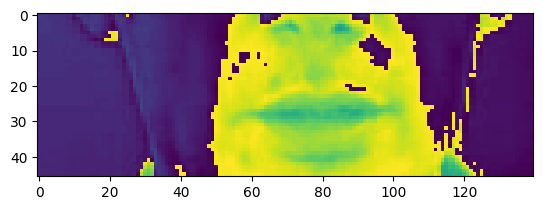

In [12]:
plt.imshow(frames[15])

**
Sets up a TensorFlow data pipeline for loading lipreading data from video file**

In [13]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

In [14]:
data = tf.data.Dataset.list_files('/kaggle/input/lipreading/data/s1/*.mpg')
data = data.shuffle(500,reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# # ADDED DOR SPLIT
train = data.take(450)
test = data.skip(450)

In [15]:
frames, alighnments = data.as_numpy_iterator().next()

In [16]:
sample = data.as_numpy_iterator()

In [17]:
val = sample.next();val[0]

array([[[[[1.2120945 ],
          [1.2120945 ],
          [0.8601962 ],
          ...,
          [0.31279862],
          [0.27369878],
          [0.27369878]],

         [[1.2120945 ],
          [1.1729947 ],
          [0.58649737],
          ...,
          [0.31279862],
          [0.27369878],
          [0.27369878]],

         [[1.4466935 ],
          [1.4466935 ],
          [1.1729947 ],
          ...,
          [0.31279862],
          [0.27369878],
          [0.27369878]],

         ...,

         [[1.1338949 ],
          [1.1338949 ],
          [1.1338949 ],
          ...,
          [0.        ],
          [0.        ],
          [0.        ]],

         [[1.0556953 ],
          [1.0556953 ],
          [1.0556953 ],
          ...,
          [9.970455  ],
          [9.970455  ],
          [9.970455  ]],

         [[1.0556953 ],
          [1.0556953 ],
          [1.0556953 ],
          ...,
          [9.970455  ],
          [9.970455  ],
          [9.970455  ]]],


        [[[1.2511

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D,Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [19]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [20]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                        

In [22]:
yhat = model.predict(val[0])

1/1 [==============================] - 9s 9s/step


In [23]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [24]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [25]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [26]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 
schedule_callback = LearningRateScheduler(scheduler)
example_callback = ProduceExample(test)

In [27]:
history = model.fit(train, validation_data=test, epochs=1, callbacks=[checkpoint_callback, schedule_callback, example_callback])

 73/450 [===>..........................] - ETA: 5:51 - loss: 111.6798

[mpeg1video @ 0x7f578408c5c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f578408c5c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 84.6061

[mpeg1video @ 0x7f5964018d00] ac-tex damaged at 22 17
[mpeg1video @ 0x7f5964018d00] Warning MVs not available
[mpeg1video @ 0x7f595006a840] ac-tex damaged at 22 17
[mpeg1video @ 0x7f595006a840] Warning MVs not available


1/1 [==============================] - 2s 2s/step
Original: laygreeninszeroplease
Prediction: leeeeee
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: binhiteinmfivesoon
Prediction: leeeee
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 891s 2s/step - loss: 84.6061 - val_loss: 70.7320 - lr: 1.0000e-04


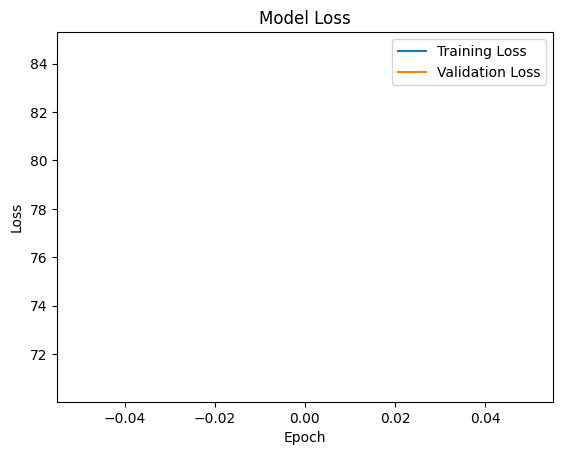

In [29]:

from matplotlib import pyplot as plt
# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [45]:
class AccuracyMetrics(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()
        self.predictions = []
        self.ground_truth = []
        self.accuracies = []  # Store accuracies at each epoch

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75, 75], greedy=False)[0][0].numpy()
        self.predictions.extend(decoded)
        self.ground_truth.extend(data[1])

# ... (your previous code)

accuracy_metrics = AccuracyMetrics(test)  # Create an instance of AccuracyMetrics

model.fit(train, validation_data=test, epochs=1, callbacks=[checkpoint_callback, schedule_callback, accuracy_metrics])

# After training, compute accuracy or any other metric using predictions and ground truth
predictions = accuracy_metrics.predictions
ground_truth = accuracy_metrics.ground_truth

# Compute accuracy (or any other suitable metric) here
# For example, using sequence_accuracy from Levenshtein distance:
from nltk.metrics.distance import edit_distance

def compute_accuracy(preds, truths):
    acc = sum(edit_distance(pred, truth) for pred, truth in zip(preds, truths)) / len(preds)
    return 1 - acc

accuracy = compute_accuracy(predictions, ground_truth)
print("Accuracy:", accuracy)

431/450 [===========================>..] - ETA: 18s - loss: 65.8018

[mpeg1video @ 0x7f5346a3eac0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f5346a3eac0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 65.8516

[mpeg1video @ 0x7f58083f6200] ac-tex damaged at 22 17
[mpeg1video @ 0x7f58083f6200] Warning MVs not available
[mpeg1video @ 0x7f53f80b9f40] ac-tex damaged at 22 17
[mpeg1video @ 0x7f53f80b9f40] Warning MVs not available


450/450 [==============================] - 861s 2s/step - loss: 65.8516 - val_loss: 61.5418 - lr: 1.0000e-04
Accuracy: -69.5


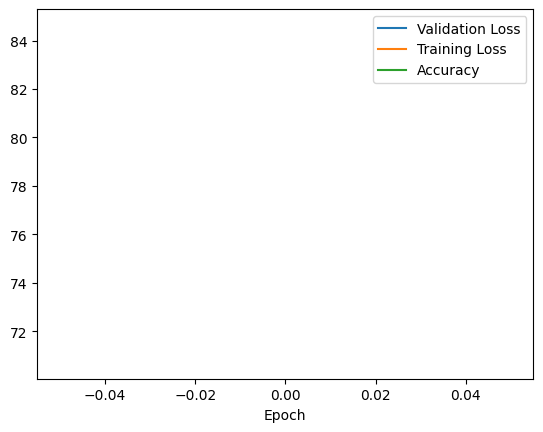

In [49]:
# After training, plot the accuracy over epochs
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(accuracy_metrics.accuracies, label='Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [47]:
# Save the model in the native Keras format
from tensorflow.keras.models import save_model
save_model(model, 'models/my_model.keras')


الحمد الله 